# **Predicción del movimiento de la acción de bolsa "S & P 500"**

## 1. Carga de librerias

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics

import sklearn
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier
!pip install pingouin
import pingouin


import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib

from mlxtend.feature_selection import SequentialFeatureSelector as SFS


import warnings
warnings.filterwarnings('ignore')
! pip install yfinance
import yfinance as yf
from datetime import datetime



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 2. Carga de Datos

Interesa conocer como se ha comportado la acción en los últimos 23 años.

In [40]:
ticker = yf.Ticker('SPY')
end_date = '2023-01-23'
start_date = '2000-01-23'
sp500 = ticker.history(start=start_date,end=end_date)
sp500.drop(columns = ['Stock Splits',	'Capital Gains','Dividends'], inplace = True)
print("Shape of SP 500 data is:", sp500.shape)
sp500.tail(5)

Shape of SP 500 data is: (5786, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2023-01-13 00:00:00-05:00,392.123443,397.582619,391.844509,396.984894,63903900
2023-01-17 00:00:00-05:00,396.964982,398.708329,395.550368,396.257660,62677300
2023-01-18 00:00:00-05:00,397.492985,398.598750,389.792363,390.001556,99632300
2023-01-19 00:00:00-05:00,387.879648,389.593110,385.787656,387.162415,86958900
2023-01-20 00:00:00-05:00,388.616855,394.534273,386.903393,394.374878,91806400


Text(0.5, 1.0, 'Matriz de correlación de OHLC de S&P500 ')

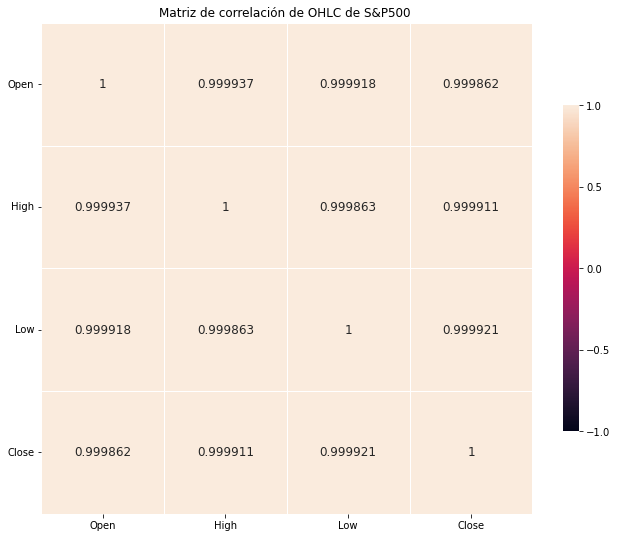

In [41]:
corr1 = sp500.drop(columns= 'Volume').corr()
 
# mask = np.zeros_like(corr1, dtype=np.bool)
# mask[np.triu_indices_from(mask)]= True
f, ax = plt.subplots(figsize=(11, 15))
heatmap1 = sns.heatmap(corr1,
                      # mask = mask,
                      square = True,
                      linewidths = .5,
                      cbar_kws = {'shrink': .4,
                                "ticks" : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 12},
                       fmt='g')
ax.set_yticklabels(corr1.columns, rotation = 0)
ax.set_xticklabels(corr1.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
plt.title("Matriz de correlación de OHLC de S&P500 ")

In [42]:
sp500.describe().round(2)

,Open,High,Low,Close,Volume
count,5786.00,5786.00,5786.00,5786.00,5.786000e+03
mean,160.73,161.69,159.67,160.73,1.094437e+08
std,104.12,104.71,103.46,104.13,9.378770e+07
min,51.64,53.20,50.99,51.76,1.436600e+06
25%,85.37,85.89,84.83,85.32,5.048282e+07
50%,107.88,108.52,106.99,107.74,8.184750e+07
75%,214.17,214.91,213.51,213.88,1.423810e+08
max,469.78,470.52,466.68,468.30,8.710263e+08


## Generate features

In [43]:
sp500['day'] = sp500.index.day
sp500['month'] = sp500.index.month
sp500['year'] = sp500.index.year
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500['is_quarter_end'] = np.where(sp500['month']%3==0,1,0)
sp500['open-close']  = sp500['Open'] - sp500['Close']
sp500['low-high']  = sp500['Low'] - sp500['High']
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]
sp500.head(3)

,Open,High,Low,Close,Volume,day,month,year,Tomorrow,is_quarter_end,...,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-24 00:00:00-05:00,95.089271,95.211678,91.009062,91.621094,7896900,24,1,2000,92.661537,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-25 00:00:00-05:00,91.733290,92.661537,90.743839,92.661537,9942500,25,1,2000,91.927116,0,...,1.005646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-26 00:00:00-05:00,92.049523,92.406541,91.457892,91.927116,5158100,26,1,2000,91.559883,0,...,0.996021,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
sp500.head(10)

,Open,High,Low,Close,Volume,day,month,year,Tomorrow,is_quarter_end,...,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-24 00:00:00-05:00,95.089271,95.211678,91.009062,91.621094,7896900,24,1,2000,92.661537,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-25 00:00:00-05:00,91.733290,92.661537,90.743839,92.661537,9942500,25,1,2000,91.927116,0,...,1.005646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-26 00:00:00-05:00,92.049523,92.406541,91.457892,91.927116,5158100,26,1,2000,91.559883,0,...,0.996021,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-27 00:00:00-05:00,92.600336,92.845149,90.172612,91.559883,10922700,27,1,2000,88.703758,0,...,0.997999,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-28 00:00:00-05:00,91.029478,91.437499,88.479347,88.703758,11916200,28,1,2000,91.111008,0,...,0.984156,0.0,0.971620,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-31 00:00:00-05:00,88.662884,91.182411,88.132457,91.111008,10768700,31,1,2000,92.008690,0,...,1.013387,1.0,0.999105,2.0,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-01 00:00:00-05:00,91.233450,92.498315,90.437810,92.008690,8419900,1,2,2000,92.090271,0,...,1.004902,2.0,1.010395,2.0,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-02 00:00:00-05:00,92.233078,92.865510,91.641448,92.090271,6205900,2,2,2000,93.477608,0,...,1.000443,2.0,1.010929,3.0,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-03 00:00:00-05:00,91.967930,93.518410,91.396701,93.477608,7997500,3,2,2000,93.089981,0,...,1.007476,2.0,1.021856,4.0,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Análisis Descriptivo

Comportamiento del cierre del precio

Text(0.5, 0, 'Años')

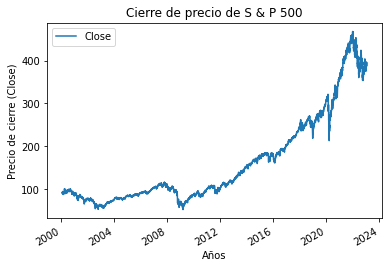

In [45]:
sp500.plot.line(y="Close", use_index=True)
plt.title("Cierre de precio de S & P 500")
plt.ylabel("Precio de cierre (Close)")
plt.xlabel("Años")

In [46]:
import plotly.graph_objects as go

from datetime import datetime


fig = go.Figure(data=[go.Candlestick(x=sp500.index,
                open=sp500['Open'],
                high=sp500['High'],
                low=sp500['Low'],
                close=sp500['Close'])])
fig.update_layout(title_text="Gráfico de velas de S&P500")

fig.show()

Histogramas de las variables de apertura (Open) y  cierre (Close) del precio asi como su valor más alto (High) y bajo (Low). 

In [47]:
sp500.shape

(5786, 23)

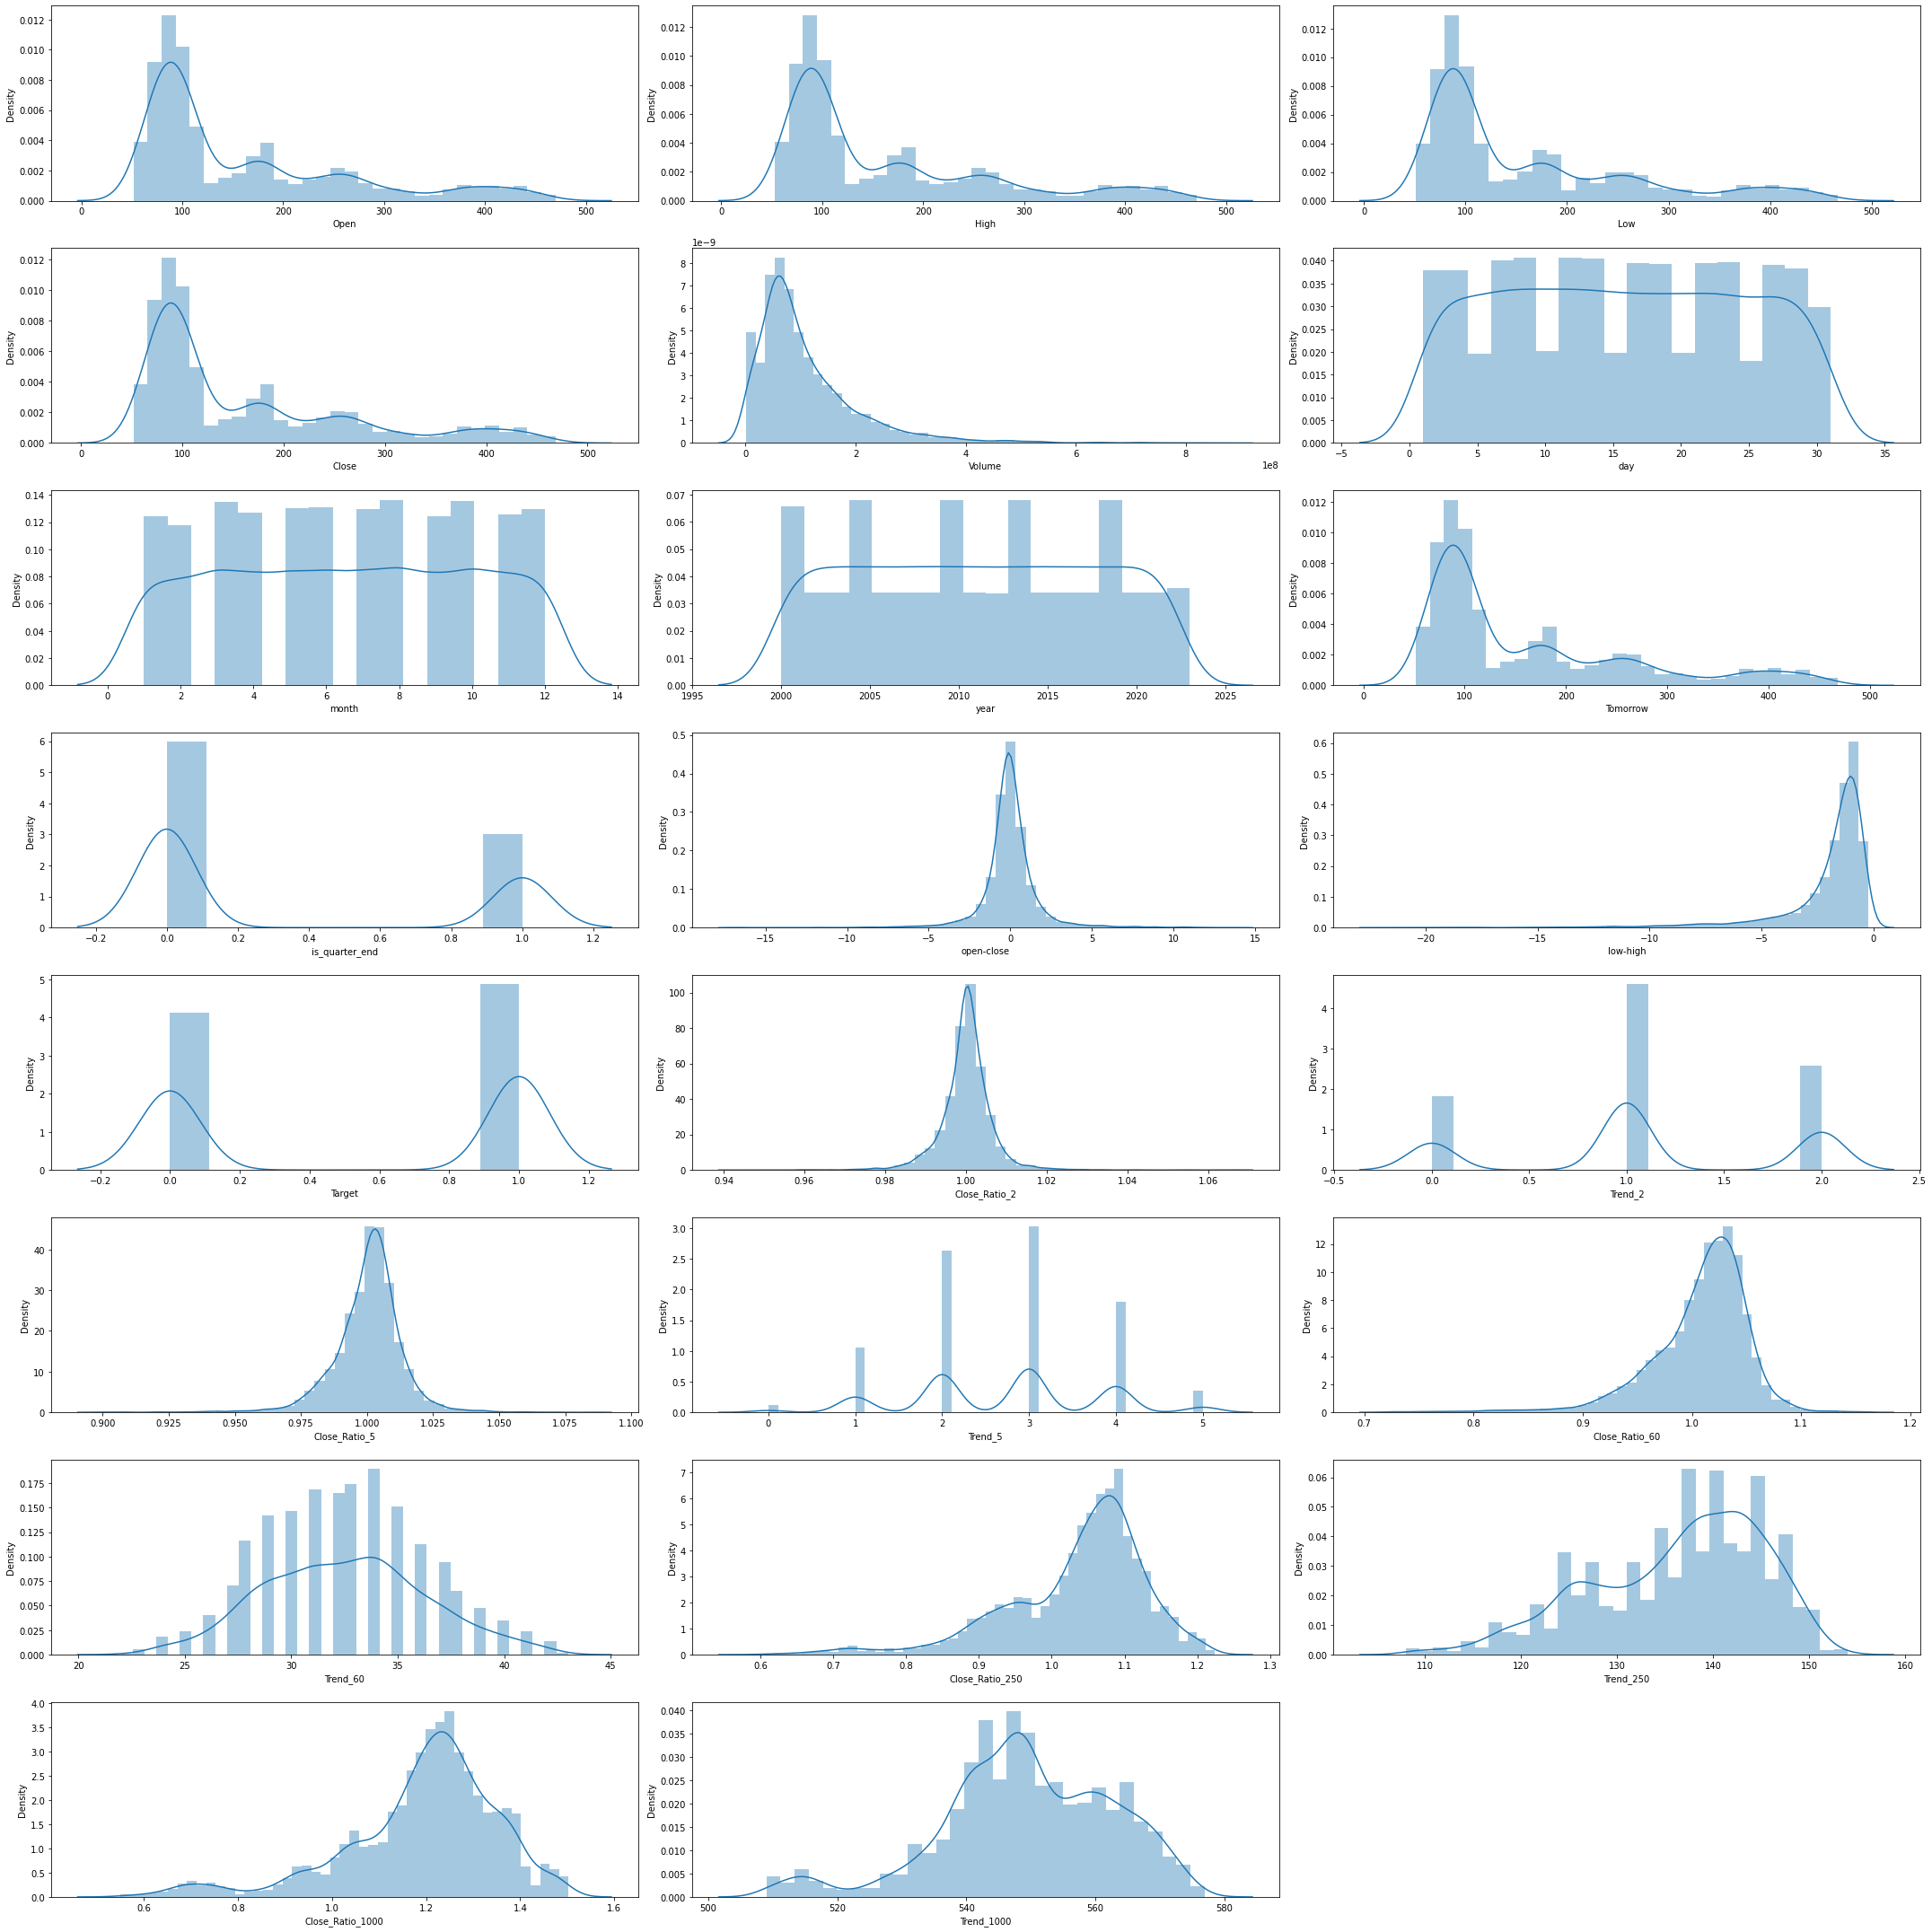

In [48]:
features =sp500.columns.to_list()  
plt.subplots(figsize=(30,30))
plt.title("Gráfico de distribución de las características y variable objetivo" )
for i, col in enumerate(features):
  plt.subplot(8,3,i+1)
  plt.tight_layout()
  sns.distplot(sp500[col])
plt.show()


* Se observa que las distribuciones tanto para Open, High , Low y Close de la acción S&P 500 se comportan similarmente. 

* Para la variable volumen tiene una distribución muy parecida a la de una Chi cuadrada.

Diagrama de cajas y bigote de las variables de apertura (Open) y  cierre (Close) del precio asi como su valor más alto (High) y bajo (Low). 

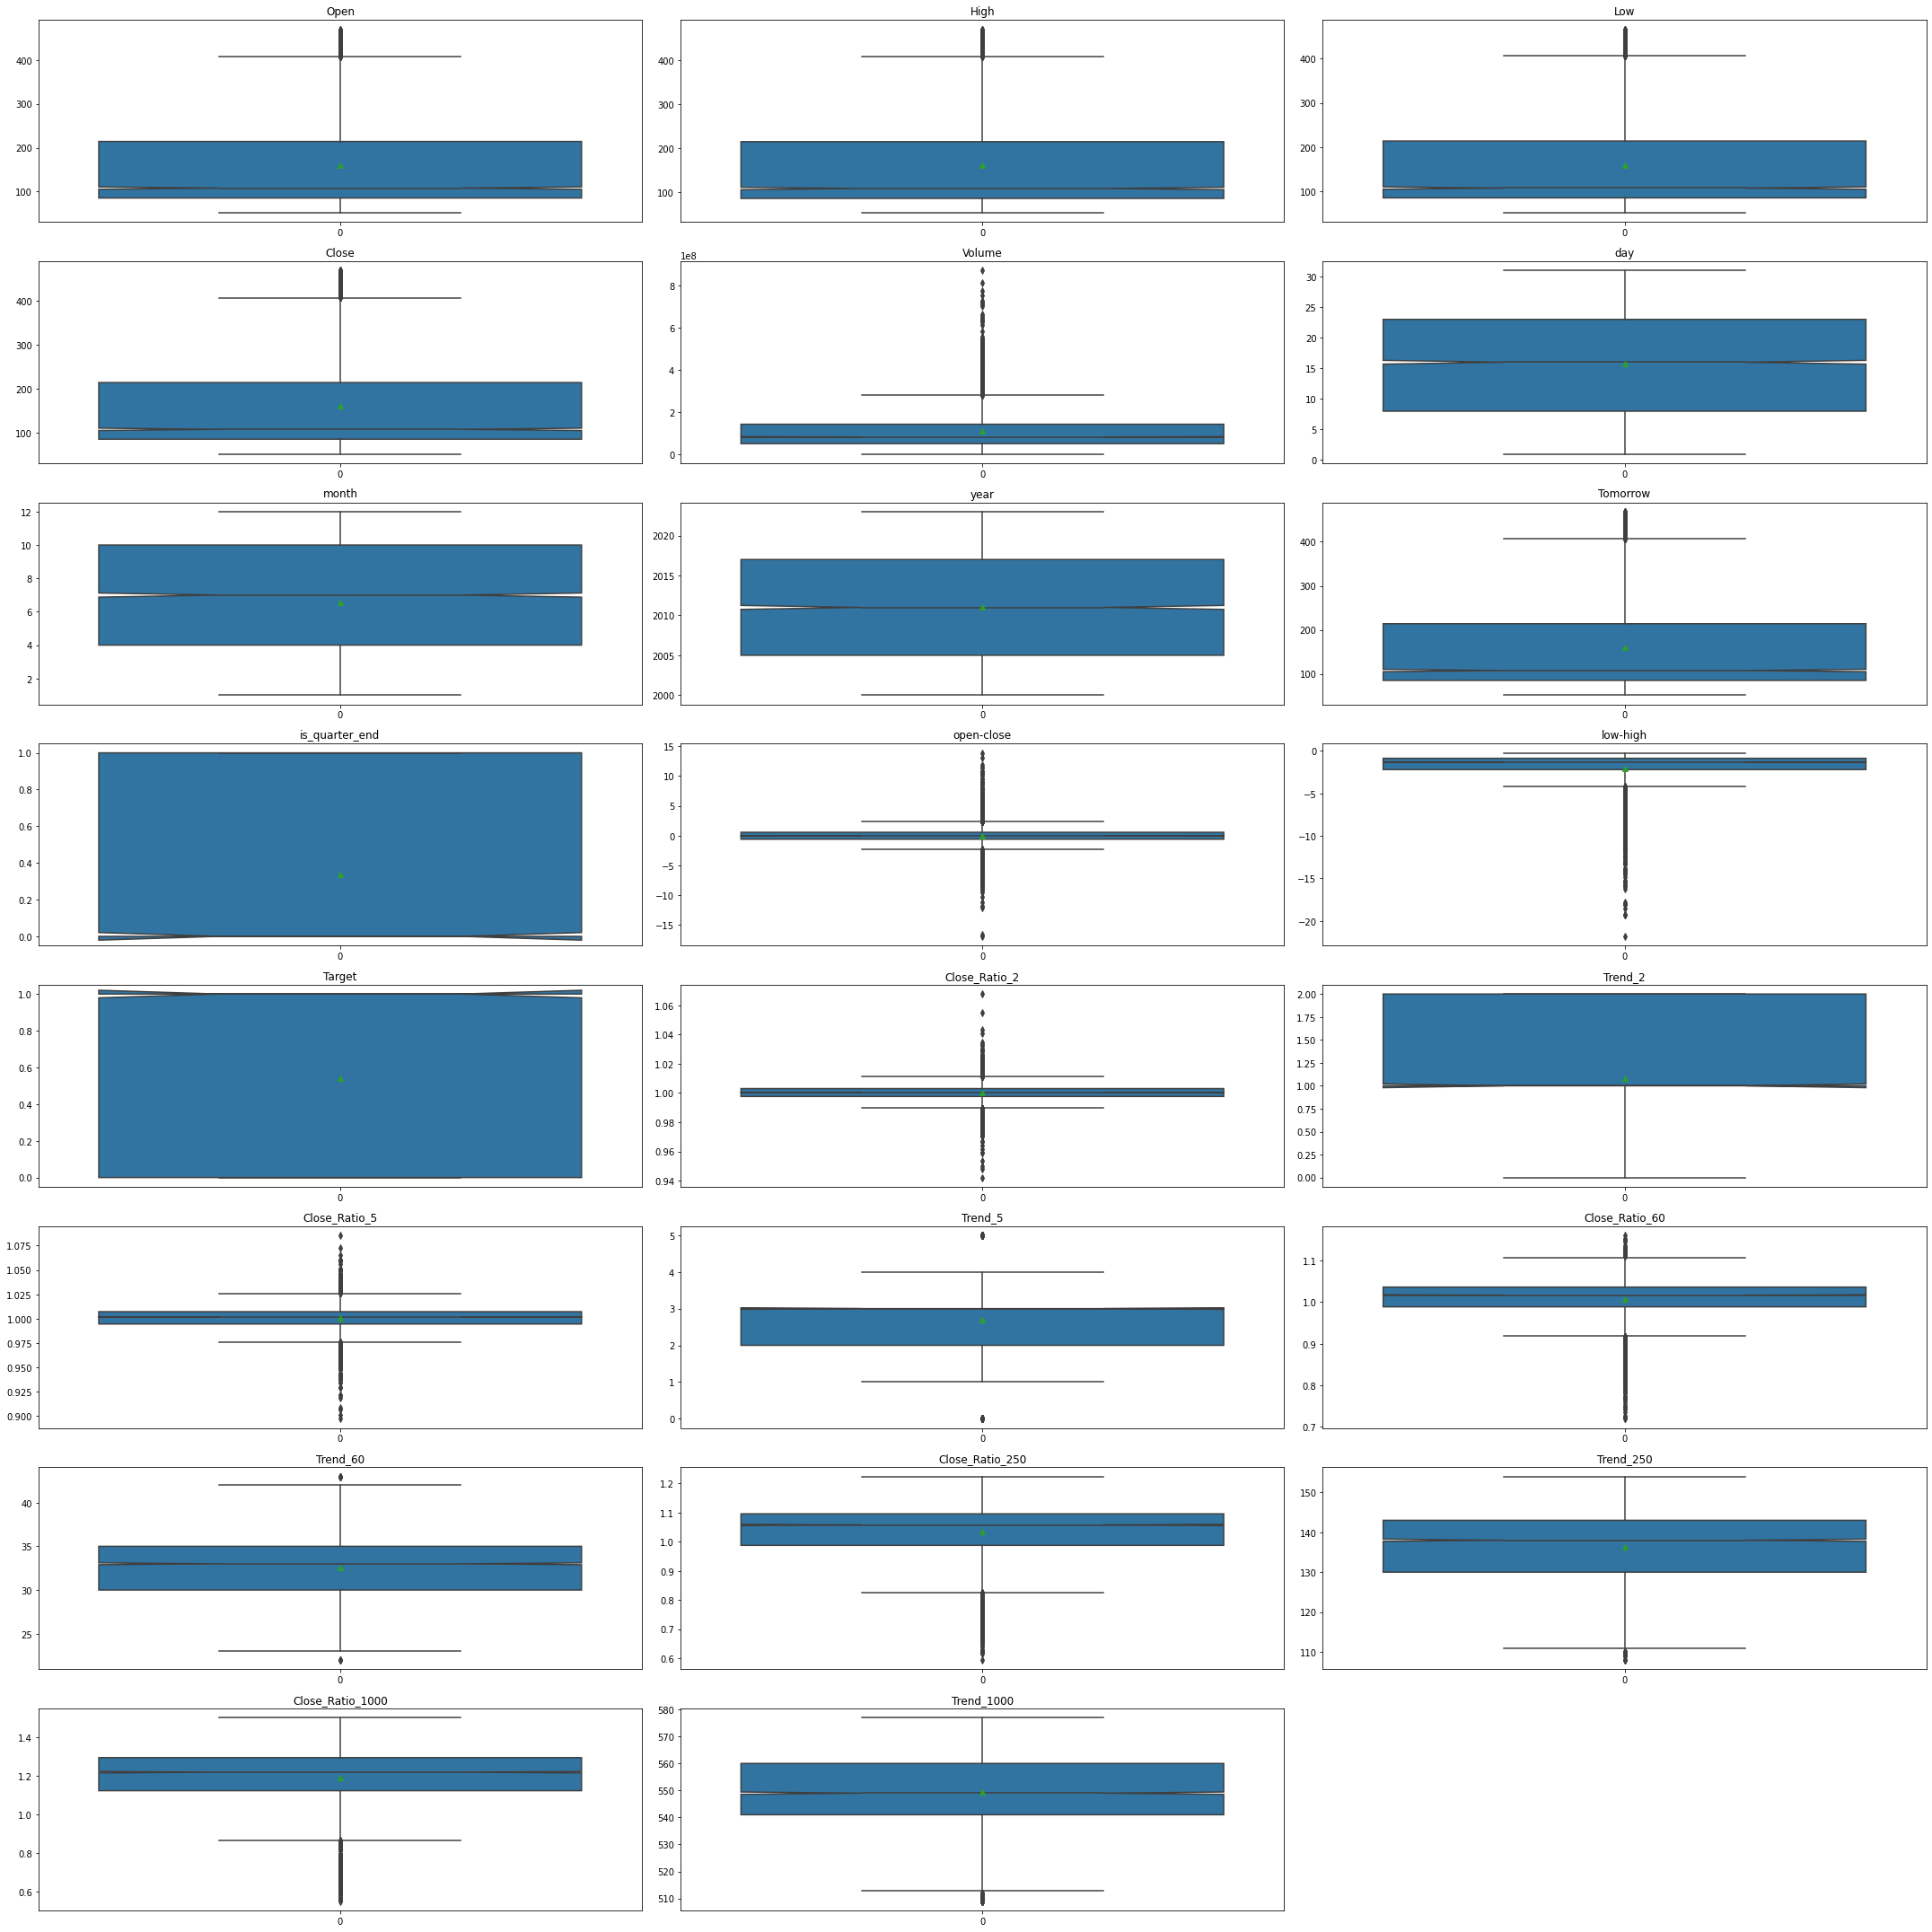

Text(0.5, 1.0, 'Gráfico de caja y bigote de las características y variable objetivo')

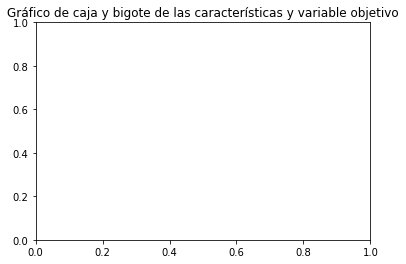

In [49]:
features =sp500.columns.to_list()  
plt.subplots(figsize=(30,30))
for i, col in enumerate(features):
  plt.subplot(8,3,i+1)
  plt.tight_layout()
  sns.boxplot(sp500[col], showmeans=True, notch=True).set(title=sp500[col].name)
plt.show()
plt.title("Gráfico de caja y bigote de las características y variable objetivo")

Es posible concluir que las variables Open, High, Low y Close se comportan similarmente, mientras que la variable volumen se concentra en el valor 1.

In [50]:
sp500.columns.to_list()  

['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'day',
 'month',
 'year',
 'Tomorrow',
 'is_quarter_end',
 'open-close',
 'low-high',
 'Target',
 'Close_Ratio_2',
 'Trend_2',
 'Close_Ratio_5',
 'Trend_5',
 'Close_Ratio_60',
 'Trend_60',
 'Close_Ratio_250',
 'Trend_250',
 'Close_Ratio_1000',
 'Trend_1000']

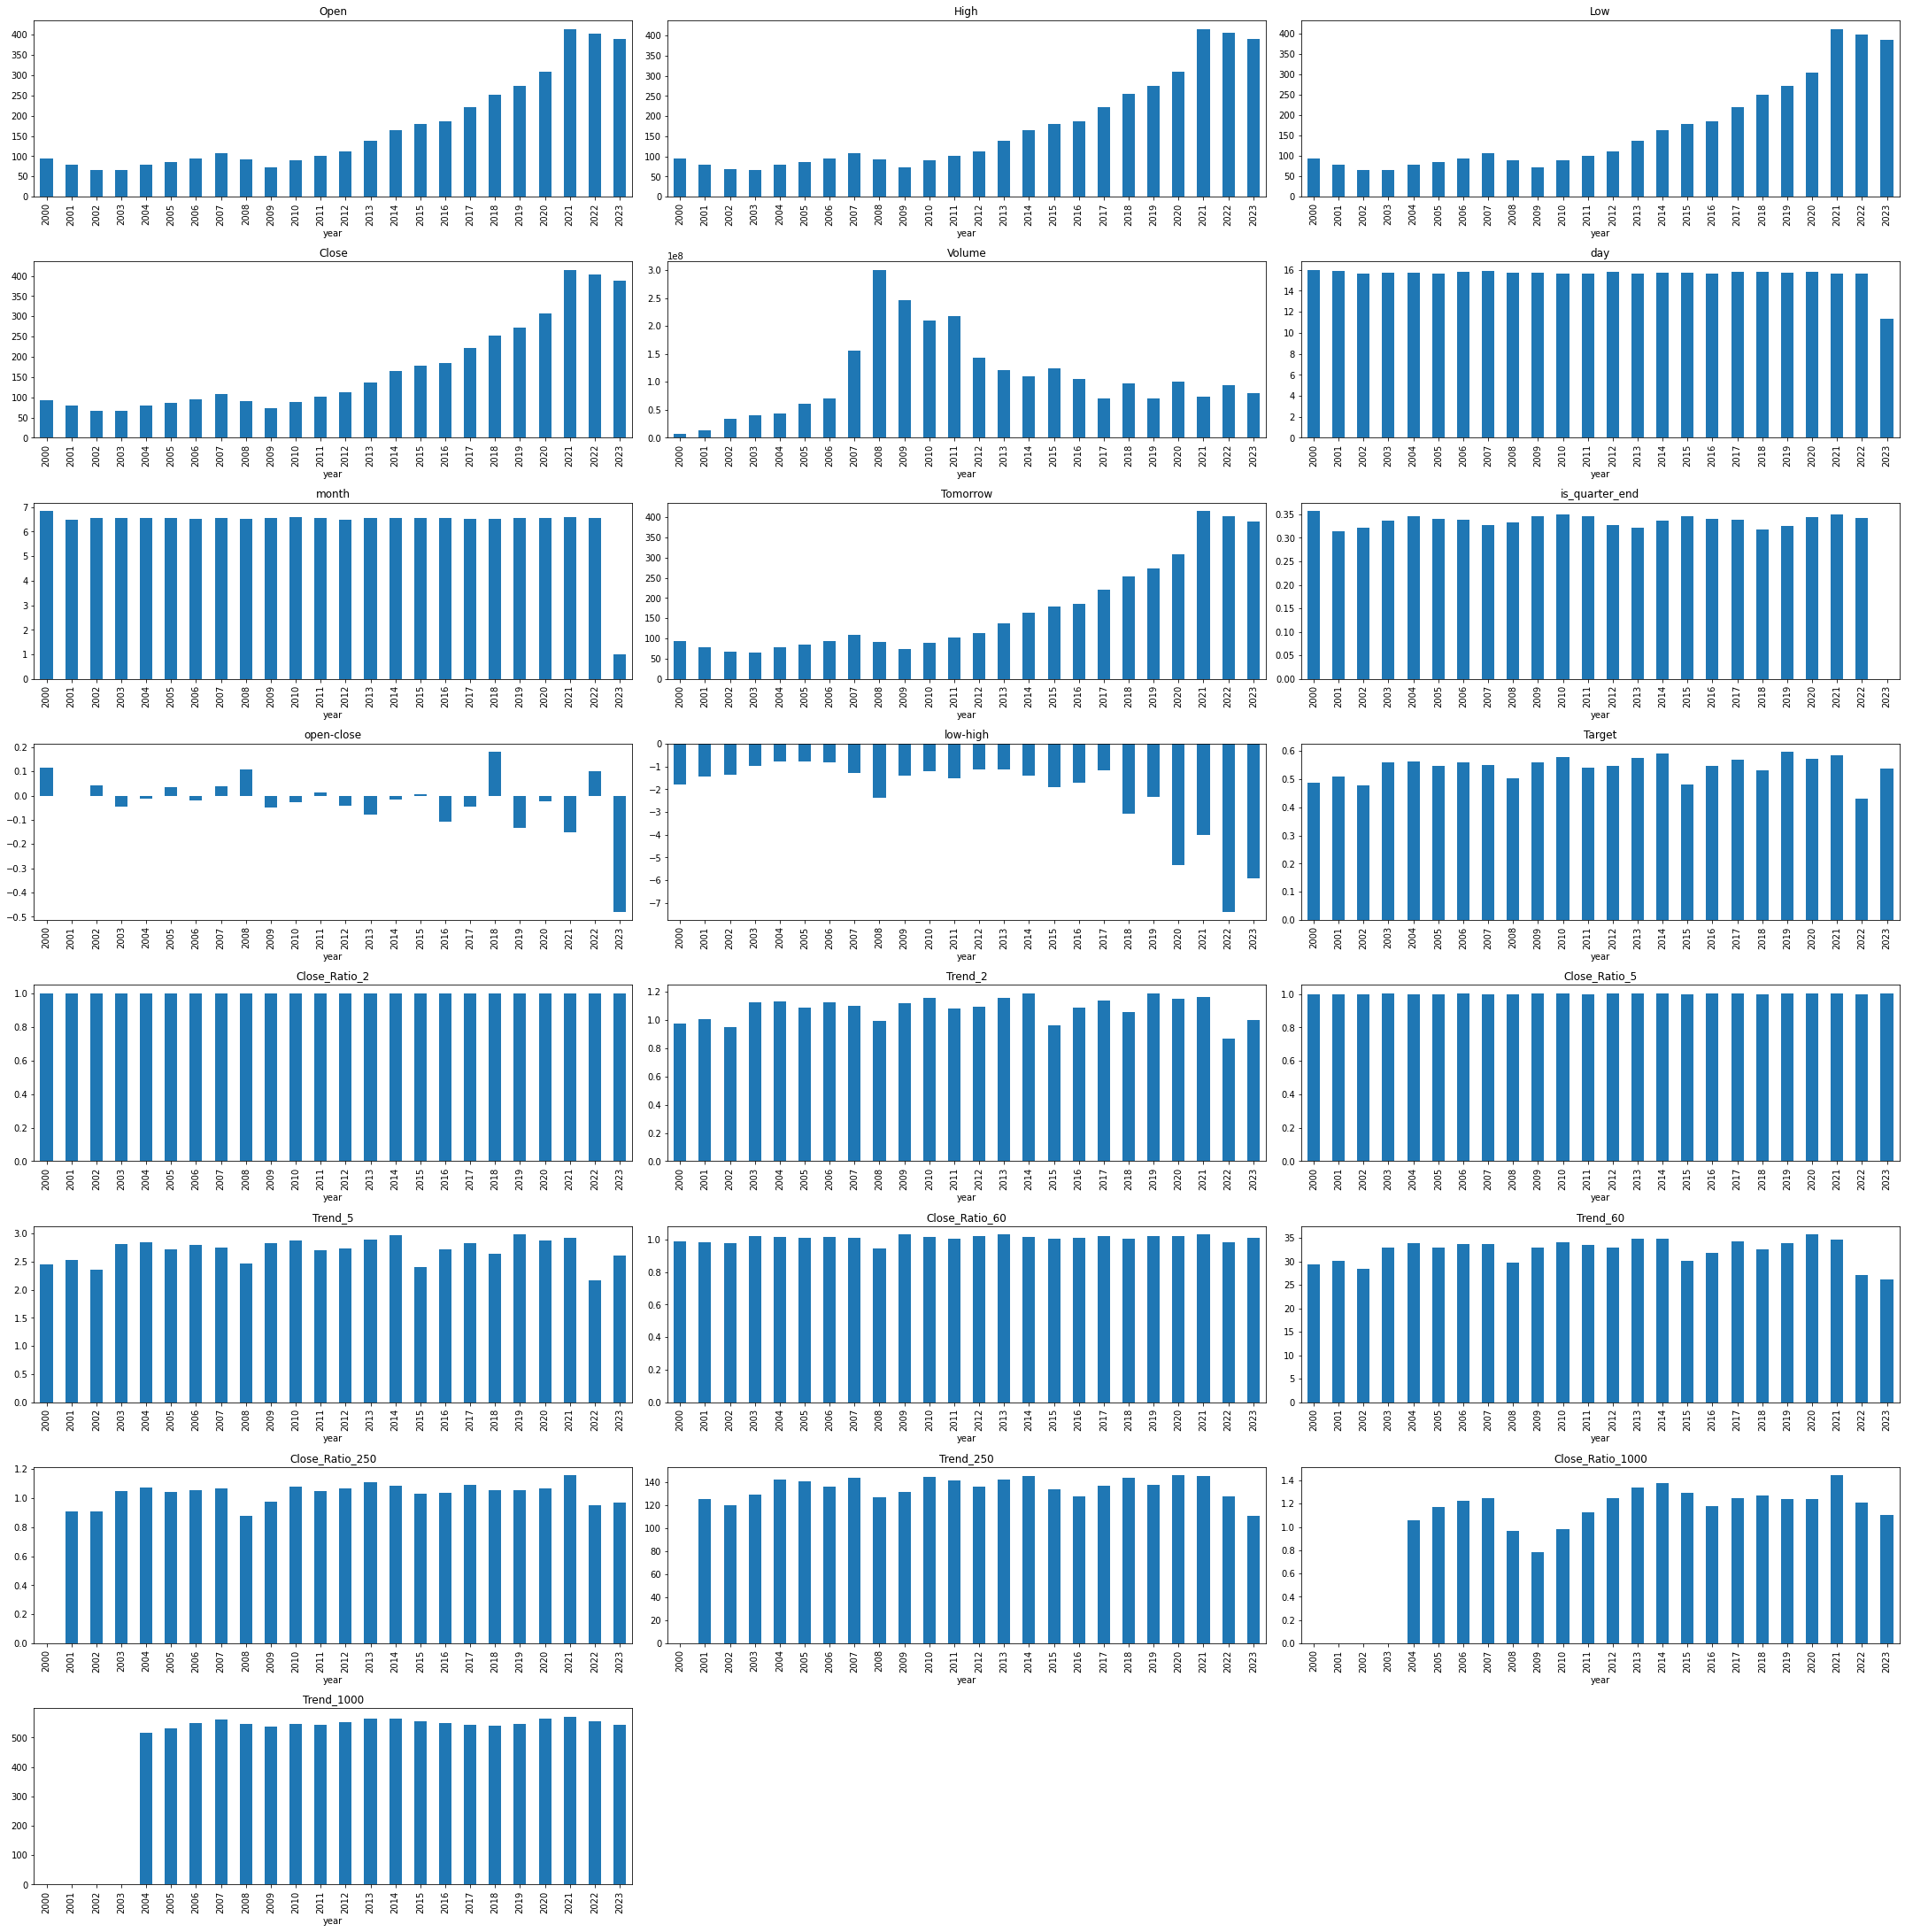

In [51]:
features_2 = ['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month',  'Tomorrow', 'is_quarter_end',
 'open-close', 'low-high', 'Target', 'Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Close_Ratio_60',
 'Trend_60', 'Close_Ratio_250', 'Trend_250', 'Close_Ratio_1000', 'Trend_1000']

data_grouped = sp500.groupby('year').mean()
plt.subplots(figsize=(30,30))
for i, col in enumerate(features_2):
  plt.subplot(8,3,i+1)
  plt.tight_layout()
  data_grouped[col].plot.bar().set(title=sp500[col].name)
plt.show()

In [52]:
sp500.groupby('is_quarter_end').mean()

,Open,High,Low,Close,Volume,day,month,year,Tomorrow,open-close,...,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
is_quarter_end,,,,,,,,,,,,,,,,,,,,,
0,160.461049,161.418266,159.426464,160.500961,1.083469e+08,15.716033,6.094742,2011.063248,160.521895,-0.039911,...,1.000205,1.102604,1.000813,2.749544,1.008510,32.522208,1.035444,136.275224,1.193350,549.349417
1,161.258411,162.236105,160.146834,161.197516,1.116114e+08,15.777263,7.433642,2011.049383,161.191585,0.060895,...,0.999970,1.045267,0.999959,2.629630,1.006318,32.593961,1.034570,136.388919,1.189217,549.373994


Descriptivos de las variables

In [53]:
sp500.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Open,5786.0,1.607300e+02,104.12,51.64,85.37,107.88,2.141700e+02,4.697800e+02
High,5786.0,1.616900e+02,104.71,53.20,85.89,108.52,2.149100e+02,4.705200e+02
Low,5786.0,1.596700e+02,103.46,50.99,84.83,106.99,2.135100e+02,4.666800e+02
Close,5786.0,1.607300e+02,104.13,51.76,85.32,107.74,2.138800e+02,4.683000e+02
Volume,5786.0,1.094437e+08,93787704.69,1436600.00,50482825.00,81847500.00,1.423810e+08,8.710263e+08
day,5786.0,1.574000e+01,8.76,1.00,8.00,16.00,2.300000e+01,3.100000e+01
month,5786.0,6.540000e+00,3.43,1.00,4.00,7.00,1.000000e+01,1.200000e+01
year,5786.0,2.011060e+03,6.63,2000.00,2005.00,2011.00,2.017000e+03,2.023000e+03
Tomorrow,5785.0,1.607500e+02,104.13,51.76,85.32,107.74,2.139100e+02,4.683000e+02
is_quarter_end,5786.0,3.400000e-01,0.47,0.00,0.00,0.00,1.000000e+00,1.000000e+00


Matriz de correlación

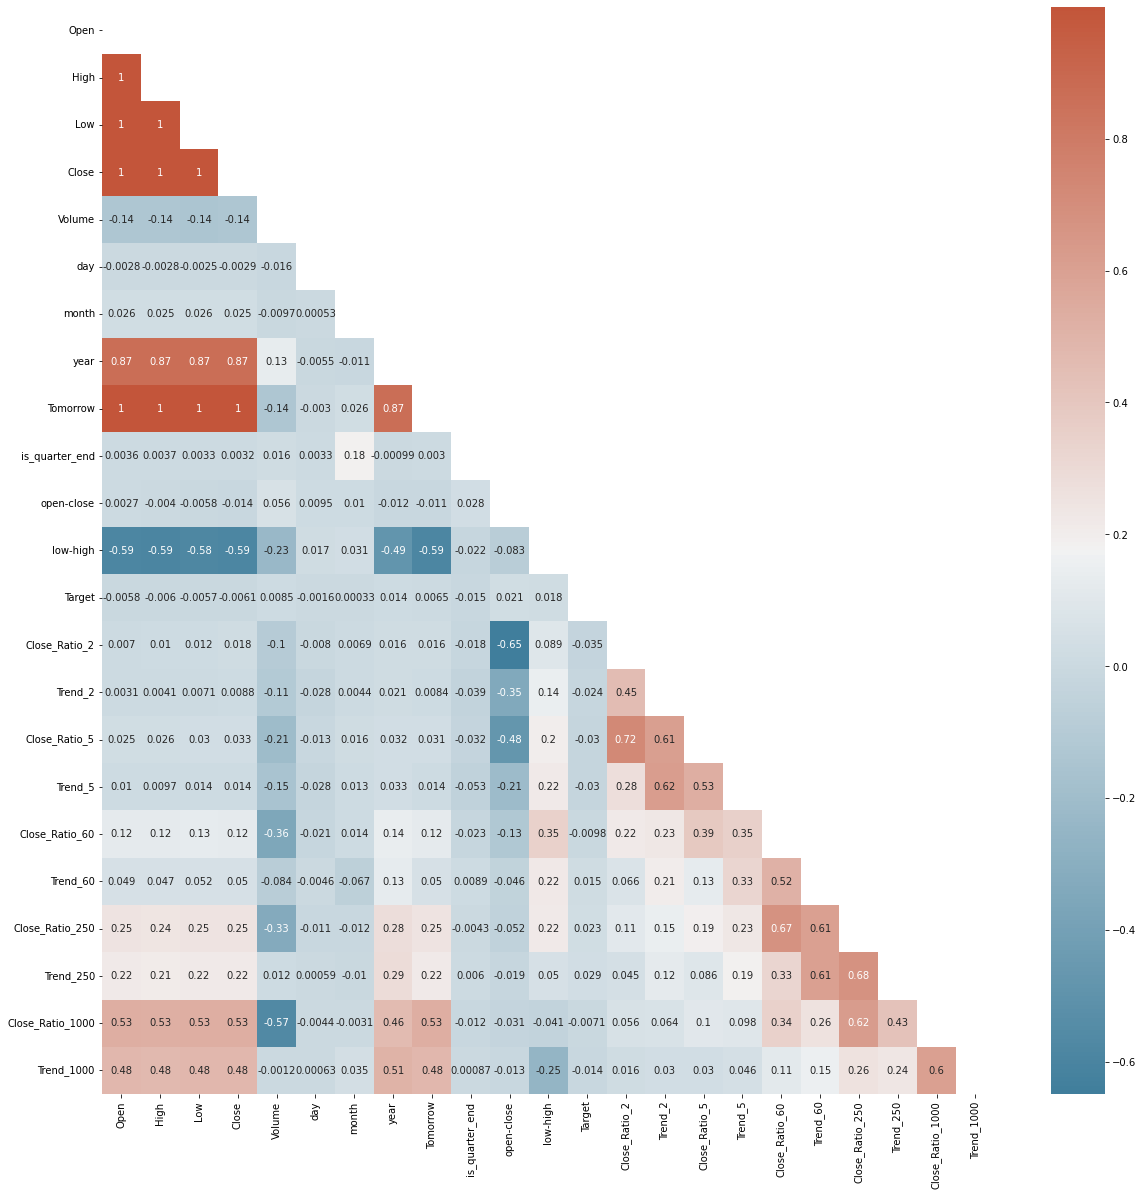

In [54]:
plt.figure(figsize=(20, 20))
 
# As our concern is with the highly
# correlated features only so, we will visualize
# our heatmap as per that criteria only.
mask = np.triu(np.ones_like(sp500.corr(), dtype=bool))
# sns.heatmap(round(sp500.corr(),2) , annot=True, cbar=False)
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
sns.heatmap(sp500.corr(), annot=True, mask = mask, cmap=cmap)
plt.show()

Se agregan características que contribuyen a que los datos que se analizan sean más significativos

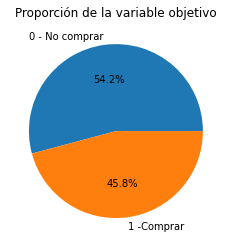

In [55]:
plt.title("Proporción de la variable objetivo")
plt.pie(sp500['Target'].value_counts().values,
        labels=["0 - No comprar", "1 -Comprar"], autopct='%1.1f%%')
plt.show()


## 4. Modelado

In [56]:

model_rf = RandomForestClassifier(n_estimators=250, min_samples_split=100, random_state=7)
sp500 = sp500.dropna()
train = sp500.iloc[:-100]
test = sp500.iloc[-100:].dropna()

predictors =['Open', 'High', 'Low', 'Close',
 'Volume', 'day', 'month', 'year',  'is_quarter_end', 'open-close', 'low-high',
 'Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5',
 'Close_Ratio_60', 'Trend_60', 'Close_Ratio_250', 'Trend_250', 'Close_Ratio_1000', 'Trend_1000']
model_rf.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, n_estimators=250, random_state=7)

In [57]:
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',n_estimators = 250,
                          random_state = 7)
sp500 = sp500.dropna()
train = sp500.iloc[:-100]
test = sp500.iloc[-100:].dropna()

predictors =['Open', 'High', 'Low', 'Close',
 'Volume', 'day', 'month', 'year',  'is_quarter_end', 'open-close', 'low-high',
 'Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5',
 'Close_Ratio_60', 'Trend_60', 'Close_Ratio_250', 'Trend_250', 'Close_Ratio_1000', 'Trend_1000']
model_xgb.fit(train[predictors], train["Target"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=7, ...)

SFS para RF

In [58]:


# sfs1_rf = SFS(model_rf, 
#            k_features=10, 
#            forward=True, 
#            floating=False, 
#            verbose=2,
#            scoring='accuracy',
#            cv=0)

# sfs1_rf = sfs1_rf.fit(sp500[predictors], sp500.Target)

In [59]:
# sfs1_rf.subsets_

SE observa que el subconjunto que aporta mejor informacion al modelo de random forest es el 10:

* {'feature_idx': (1, 5, 9, 11, 13, 14, 15, 17, 19, 20),
*  'cv_scores': array([0.75653083]),
*  'avg_score': 0.7565308254963428,
*  'feature_names': (
      * 'High',
      *   'day',
      *   'open-close',
      *   'Close_Ratio_2',
      *   'Close_Ratio_5',
      *   'Trend_5',
      *   'Close_Ratio_60',
      *   'Close_Ratio_250',
      *   'Close_Ratio_1000',
      *   'Trend_1000')}}

XGB para SFS

In [60]:
# sfs1_xgb = SFS(model_xgb, 
#            k_features=10, 
#            forward=True, 
#            floating=False, 
#            verbose=2,
#            scoring='accuracy',
#            cv=0)

# sfs1_xgb = sfs1_xgb.fit(sp500[predictors], sp500.Target)

In [61]:
# sfs1_xgb.subsets_

In [62]:
model_rf2 = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)
sp500 = sp500.dropna()
train = sp500.iloc[:-100]
test = sp500.iloc[-100:].dropna()

subset_sel = ['High',   'day',   'open-close',   'Close_Ratio_2',  
              'Close_Ratio_5',   'Trend_5',   'Close_Ratio_60',   
              'Close_Ratio_250',   'Close_Ratio_1000',   'Trend_1000']

model_rf2.fit(train[subset_sel], train["Target"])

pred = model_rf2.predict(test[subset_sel])  
precision_score(test.Target, pred)

0.40217391304347827

In [63]:
model_xgb2 =model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

sp500 = sp500.dropna()
train = sp500.iloc[:-100]
test = sp500.iloc[-100:].dropna()

subset_sel = ['Close',   'Volume',   'month',
   'open-close',   'Close_Ratio_2',   'Close_Ratio_5',
   'Close_Ratio_60',   'Close_Ratio_250',   'Trend_250',   'Close_Ratio_1000']

model_xgb2.fit(train[subset_sel], train["Target"])

predxgb = model_xgb2.predict(test[subset_sel])
precision_score(test.Target, predxgb)

0.41379310344827586

In [64]:
def predict(train, test, predictors, model):
    model.fit(train[subset_sel], train["Target"])
    preds = model.predict(test[subset_sel])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [65]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
        # print(i)
    return pd.concat(all_predictions)

In [66]:
predictions_rf = backtest(sp500, model_rf2, predictors)
print(precision_score(predictions_rf["Target"], predictions_rf["Predictions"]))
print('\n')
print(predictions_rf["Target"].value_counts() / predictions_rf.shape[0])
cf_rf = sklearn.metrics.confusion_matrix(predictions_rf.Target, predictions_rf.Predictions)
print(cf_rf)

0.5338417540514776


1    0.544858
0    0.455142
Name: Target, dtype: float64
[[551 489]
 [685 560]]


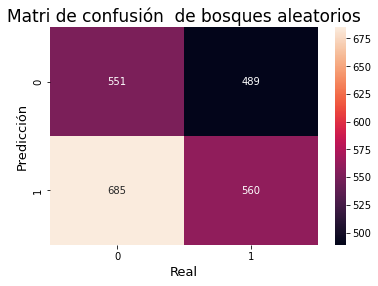

In [79]:
sns.heatmap(cf_rf,
            annot=True,
            fmt='g',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.ylabel('Predicción',fontsize=13)
plt.xlabel('Real',fontsize=13)
plt.title('Matri de confusión  de bosques aleatorios',fontsize=17)
plt.show()

In [67]:
predictions_xgb = backtest(sp500, model_xgb2, predictors)
print(precision_score(predictions_xgb["Target"], predictions_xgb["Predictions"]))
print('\n')
print(predictions_xgb["Target"].value_counts() / predictions_xgb.shape[0])
cf_xgb = sklearn.metrics.confusion_matrix(predictions_xgb.Target, predictions_xgb.Predictions)
print(cf_xgb)

0.536318407960199


1    0.544858
0    0.455142
Name: Target, dtype: float64
[[574 466]
 [706 539]]


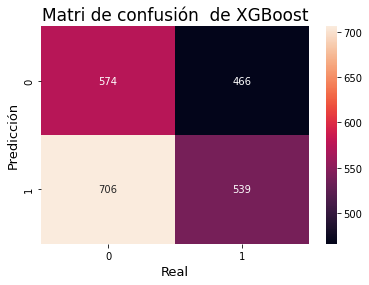

In [80]:
sns.heatmap(cf_xgb,
            annot=True,
            fmt='g',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.ylabel('Predicción',fontsize=13)
plt.xlabel('Real',fontsize=13)
plt.title('Matri de confusión  de XGBoost',fontsize=17)
plt.show()

# Diseño de Experimentos (DoE)

In [68]:
predictions_xgb = predictions_xgb.rename(columns = {"Predictions" : "Pred_xgb"}) 
predictions_rf = predictions_rf.rename(columns = {"Predictions" : "Pred_rf"}) 
predictions_xgb.head(3)

,Target,Pred_xgb
Date,,
2013-12-20 00:00:00-05:00,1,0
2013-12-23 00:00:00-05:00,1,1
2013-12-24 00:00:00-05:00,1,0


In [69]:
pd.melt(predictions_rf.drop(columns = "Target") )

,variable,value
0,Pred_rf,0
1,Pred_rf,0
2,Pred_rf,0
3,Pred_rf,0
4,Pred_rf,0
...,...,...
2280,Pred_rf,1
2281,Pred_rf,1
2282,Pred_rf,1
2283,Pred_rf,1


In [70]:
predicciones2 = pd.concat([pd.melt(predictions_xgb), pd.melt(predictions_rf.drop(columns = "Target") )], axis=0)

In [71]:
predicciones2.groupby('variable').size()

variable
Pred_rf     2285
Pred_xgb    2285
Target      2285
dtype: int64

In [72]:
predicciones2.groupby('variable').agg(['mean', 'std'])

value          
              mean       std
variable                    
Pred_rf   0.459081  0.498432
Pred_xgb  0.439825  0.496474
Target    0.544858  0.498093

<Axes: title={'center': 'Diagrama de caja y bigotes para las predicciones del árbol de decisión, XGBoost y el valor real'}, xlabel='variable', ylabel='value'>

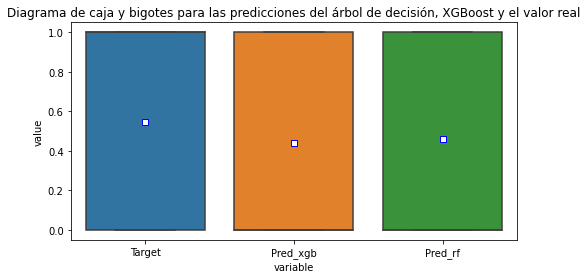

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
plt.title("Diagrama de caja y bigotes para las predicciones del árbol de decisión, XGBoost y el valor real")
sns.boxplot(x="variable", y="value", data=predicciones2, ax=ax, showmeans = True,
            meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"})
# sns.swarmplot(x="variable", y="value", data=predicciones2, color='black', alpha = 0.5, ax=ax);


In [74]:
import pingouin as pg #test de normalidad Shapiro-Wilk
pg.normality(data=predicciones2, dv='value', group='variable')


,W,pval,normal
variable,,,
Target,0.633683,0.0,False
Pred_xgb,0.631342,0.0,False
Pred_rf,0.634168,0.0,False


Los datos no siguen una distribución normal.

In [75]:
#Test de homocedasticidad
pg.homoscedasticity(data=predicciones2, dv='value', group='variable', method='levene')

,W,pval,equal_var
levene,0.954768,0.384953,True


No hay evidencia significativa que indique homocedasticidad

In [76]:
Lpg.pairwise_tukey(data=predicciones2, dv='value', between='variable').round(3)

NameError: ignored

In [ ]:
# Test ANOVA de una vía (One-way ANOVA)
# ==============================================================================
pg.anova(data=predicciones2, dv='value', between='variable', detailed=True)

### Conclusión DoE

Es importante destacar que los datos no siguen una distribución normal. Sin embargo se continuo con el Diseño de Experimentos y se concluyo que como el  p-value es muy cercano a cero y el  alfa de 0.05. 

Se conoce que se rechaza $H_0$ si pvalor es menor a $\alpha$.

Entonces, se rechaza $H_0$ ,  los grupos que se compararon no tienen la misma media.

[Literatura citada](https://www.cienciadedatos.net/documentos/pystats09-analisis-de-varianza-anova-python.html)



## Citas

* https://www.youtube.com/watch?v=1O_BenficgE
* https://github.com/dataquestio/project-walkthroughs/blob/master/sp_500/market_prediction.ipynb
* http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/#sequential-forward-selection-sfs
* https://iopscience.iop.org/article/10.1088/1742-6596/2161/1/012065/pdf
* file:///C:/Users/Maria%20Luisa/Downloads/Successful%20Algorithmic%20Trading.pdf